# Brain Tumor MRI Classification

Bu projede, MRI görüntüleri üzerinde derin öğrenme tabanlı bir Convolutional Neural Network (CNN) modeli geliştirilmiştir. Model, Pituitary, Meningioma, Glioma ve No Tumor olmak üzere dört farklı sınıfı otomatik ve güvenilir bir şekilde sınıflandırabilmektedir. Projenin amacı, tümör tiplerini hızlı ve doğru bir şekilde tahmin edebilen bir model oluşturmaktır.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import datetime
import tensorflow as tf
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# GPU kullanılabilirliğini kontrol edelim
print("GPU kullanılabilir mi?", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")

GPU kullanılabilir mi? Evet


## Kullanılan Kütüphaneler

Bu projede aşağıdaki Python kütüphaneleri kullanılmıştır:

- **tensorflow / keras**: Derin öğrenme modellerini oluşturmak, eğitmek ve değerlendirmek için.
- **sklearn**: Model performansını değerlendirmek ve sınıf ağırlıklarını hesaplamak için.
- **numpy / pandas**: Veri işlemleri ve dizin manipülasyonları için.
- **matplotlib / seaborn**: Görselleştirme ve grafik çizimleri için.
- **PIL (Python Imaging Library)**: Görüntü işleme ve dosya yükleme işlemleri için.
- **datetime**: TensorBoard log dizinlerini zaman damgası ile oluşturmak için.
- **os / random / warnings**: Dosya yönetimi, rastgele seçimler ve uyarıları yönetmek için.

## 1. Veri Keşfi

Projede kullanılan veri seti, dört sınıf içerir: **Pituitary, Meningioma, Glioma ve No Tumor**. Veri seti, `Training` ve `Testing` olmak üzere iki ana klasöre ayrılmıştır.

In [3]:
# Dosya yolları
base_dir = "/kaggle/input/brain-tumor-mri-dataset"
train_path = os.path.join(base_dir, "Training")
test_path = os.path.join(base_dir, "Testing")

In [4]:
print("Train klasörü:", train_path)
print("Test klasörü:", test_path)

Train klasörü: /kaggle/input/brain-tumor-mri-dataset/Training
Test klasörü: /kaggle/input/brain-tumor-mri-dataset/Testing


Veri setindeki sınıflar ve her sınıftaki görsel sayıları aşağıdaki gibidir:

In [5]:
classes = os.listdir(train_path)
print("Sınıflar:", classes)
print("Sınıf Sayısı:",len(classes))

Sınıflar: ['pituitary', 'notumor', 'meningioma', 'glioma']
Sınıf Sayısı: 4


In [6]:
print("Train veri setindeki sınıfların görsel sayısı:\n")
for c in classes:
    class_count = len(os.listdir(os.path.join(train_path, c)))
    print(f"{c}: {class_count} görsel")

Train veri setindeki sınıfların görsel sayısı:

pituitary: 1457 görsel
notumor: 1595 görsel
meningioma: 1339 görsel
glioma: 1321 görsel


In [7]:
print("Test veri setindeki sınıfların görsel sayısı:\n")
for c in classes:
    class_count = len(os.listdir(os.path.join(test_path, c)))
    print(f"{c}: {class_count} görsel")

Test veri setindeki sınıfların görsel sayısı:

pituitary: 300 görsel
notumor: 405 görsel
meningioma: 306 görsel
glioma: 300 görsel


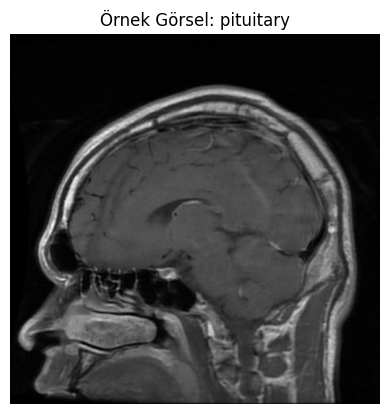

Görselin boyutu: (512, 512)


In [8]:
# Örnek bir görsel gösterilir
sample_img_path = os.path.join(train_path, classes[0], os.listdir(os.path.join(train_path, classes[0]))[0])
sample_img = Image.open(sample_img_path)

plt.imshow(sample_img)
plt.title(f"Örnek Görsel: {classes[0]}")
plt.axis("off")
plt.show()

print("Görselin boyutu:", sample_img.size)

## 2. Veri Görselleştirme ve Analiz

Veri setindeki her sınıftan rastgele seçilen 4 tane örnek görsel aşağıda gösterilmiştir. Bu görseller, sınıflar arasındaki farkları ve MRI görüntülerinin genel yapısını görselleştirmek için kullanılmıştır.

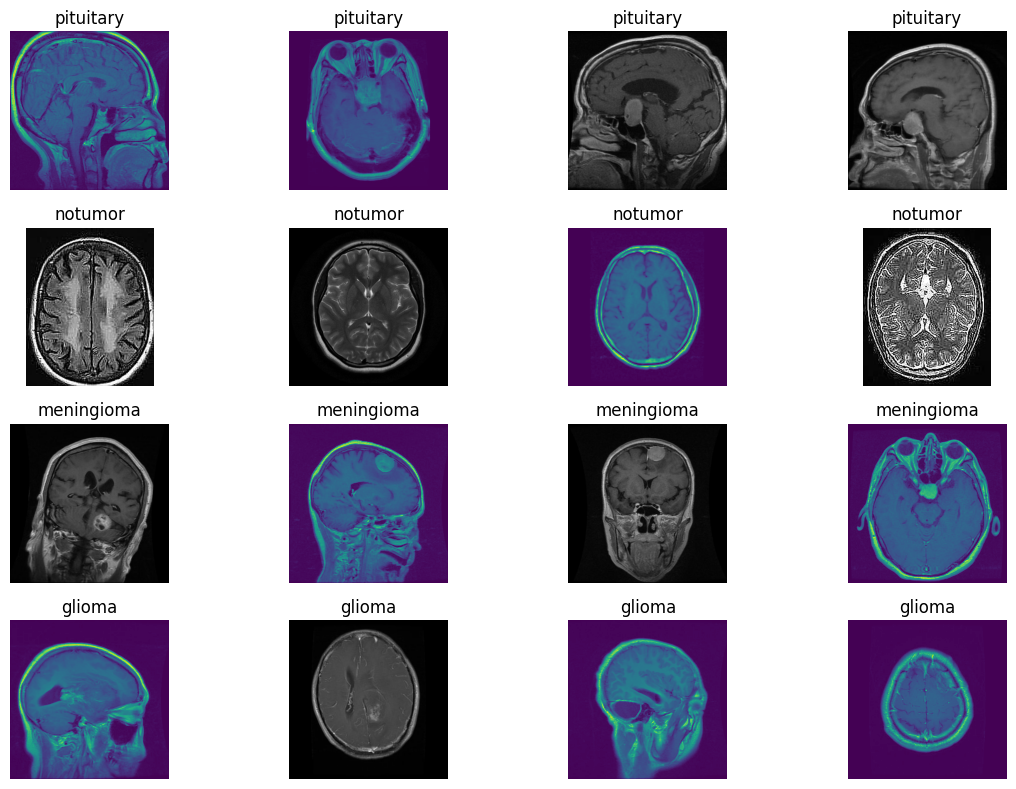

In [9]:
def show_sample_images(base_path, classes, samples_per_class=4):
    plt.figure(figsize=(12, 8))
    
    for i, c in enumerate(classes):
        class_path = os.path.join(base_path, c)
        images = os.listdir(class_path)
        sample_images = random.sample(images, samples_per_class)
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            
            plt.subplot(len(classes), samples_per_class, i*samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(c)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

show_sample_images(train_path, classes)

Bar Chart ile sınıf dağılımı görselleştirilmiştir ve her sınıftaki görsel sayısı aşağıdaki grafik ile sunulmuştur:

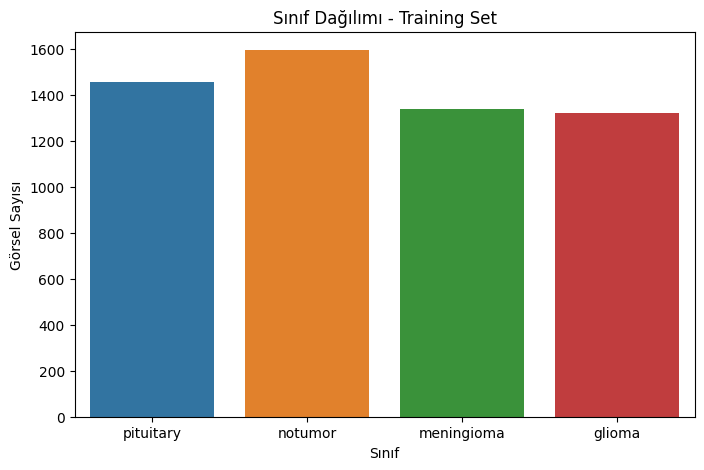

In [10]:
class_counts = {
    c: len(os.listdir(os.path.join(train_path, c))) for c in classes
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Sınıf Dağılımı - Training Set")
plt.xlabel("Sınıf")
plt.ylabel("Görsel Sayısı")
plt.show()

Veri dağılımı genel olarak dengeli görünse de, No Tumor sınıfında biraz daha fazla görüntü bulunmaktadır.
Bu durum modelin öğrenme sürecinde hafif bir sınıf dengesizliği yaratabilir. Özellikle az sayıda örneğe sahip sınıflar, model tarafından yeterince öğrenilmeyebilir.

Önlem olarak:
- Eğitim sırasında class_weight parametresi kullanılmıştır.
- Böylece model, az sayıda örneğe sahip sınıflara daha fazla önem vererek daha dengeli bir öğrenme gerçekleştirebilir.
- Ayrıca veri artırma (data augmentation) teknikleriyle her sınıfın çeşitliliği artırılarak modelin genelleme yeteneği geliştirilmiştir.

Bu sayede model, her sınıf için daha adil bir şekilde tahmin yapabilir ve overfitting riski azaltılmış olur.

#### Train ve Test veri setlerini karşılaştırırız

Her sınıftaki görsel sayısını ve veri setlerinin toplam büyüklüğünü incelemek, modelin eğitim ve değerlendirme aşamalarında veri dengesini anlamak için önemlidir. Aşağıdaki kod ile hem toplam görsel sayıları hem de sınıf bazlı dağılımlar hesaplanmıştır:

In [11]:
def count_images(base_path):
    counts = {c: len(os.listdir(os.path.join(base_path, c))) for c in classes}
    total = sum(counts.values())
    return total, counts

In [12]:
train_total, train_counts = count_images(train_path)
test_total, test_counts = count_images(test_path)

print("Training Set Toplam:", train_total)
print("Testing Set Toplam:", test_total)

Training Set Toplam: 5712
Testing Set Toplam: 1311


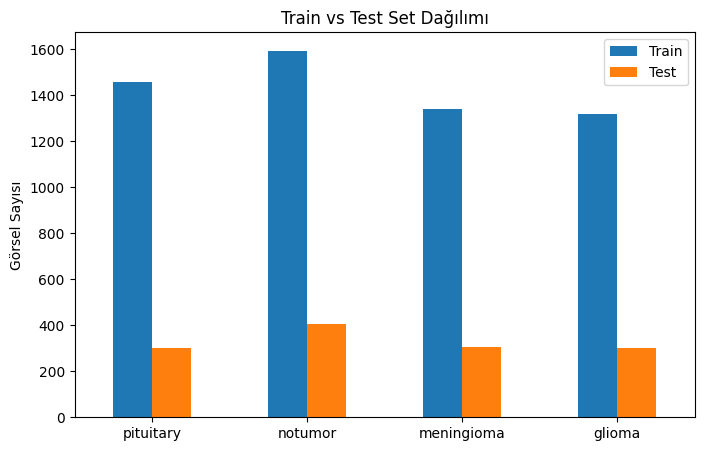

In [13]:
df_counts = pd.DataFrame({"Train": train_counts, "Test": test_counts})
df_counts.plot(kind="bar", figsize=(8,5))
plt.title("Train vs Test Set Dağılımı")
plt.ylabel("Görsel Sayısı")
plt.xticks(rotation=0)
plt.show()

#### Train veri setindeki görsellerin boyut dağılımına bakarız

Model eğitimi öncesinde veri setindeki görsellerin boyutlarını ve sınıf dağılımını incelemek önemlidir. Bu analiz, modelin giriş boyutlarına göre ön işleme ve veri dengesi hakkında bilgi verir.

Aşağıdaki kod ile tüm eğitim görsellerinin genişlik ve yükseklik değerleri hesaplanmıştır ve histogram ile görselleştirilmiştir:

In [14]:
widths, heights = [], []

for c in classes:
    for img_name in os.listdir(os.path.join(train_path, c)):
        img_path = os.path.join(train_path, c, img_name)
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)

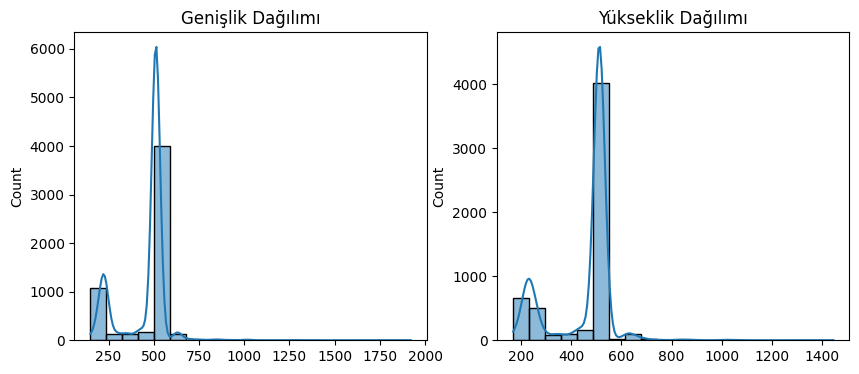

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(widths, bins=20, kde=True)
plt.title("Genişlik Dağılımı")

plt.subplot(1,2,2)
sns.histplot(heights, bins=20, kde=True)
plt.title("Yükseklik Dağılımı")

plt.show()

## 3. Veri Ön İşleme ve Data Augmentation

Bu aşamada, modelimizin eğitim ve doğrulama sürecine başlamadan önce veri setini uygun formata getirdik ve çeşitlendirme işlemleri uyguladık.

1. Görsellerin Yeniden Boyutlandırılması
- Tüm görseller, modelin giriş boyutuna uygun şekilde 150x150 piksel boyutuna getirildi. Bu sayede farklı boyutlardaki görseller tek bir standarda çekilmiş oldu.

2. Piksel Değerlerinin Normalizasyonu
- Görsellerin piksel değerleri 0-255 aralığından 0-1 aralığına normalize edildi.  
- Böylece model, büyük piksel değerlerinden etkilenmeden daha stabil öğrenme yapabilir.

3. Data Augmentation
- Modelin genelleme yeteneğini artırmak ve modelin overfitting yapmasını önlemek için eğitim verisi üzerinde çeşitli dönüşümler uygulandı :
    - **Rescale:** Piksel değerleri 0-1 aralığına normalize edilmiştir.
    - **Rotation:** Görseller ±20 derece döndürülmüştür.
    - **Width & Height Shift:** Yatay ve dikey kaydırmalar (%10) uygulanmıştır.
    - **Shear:** Görseller üzerinde kesme (shear) işlemi yapılmıştır.
    - **Zoom:** Görseller %10 oranında yakınlaştırılmıştır.
    - **Horizontal Flip:** Yatay çevirme uygulanmıştır.
    - **Fill Mode:** Boş kalan pikseller `nearest` yöntemi ile doldurulmuştur.
    - **Validation Split:** Eğitim setinin %20'si doğrulama (validation) için ayrılmıştır.

4. Test Seti
- Test setindeki görseller sadece **normalize edildi**, herhangi bir augmentasyon uygulanmadı. Bu, model performansını gerçekçi şekilde değerlendirmemizi sağlar.

5. Sınıflandırma Tipi
- `class_mode='categorical'` kullanılarak çok sınıflı (4 sınıf) sınıflandırma yapıldı.

In [16]:
img_height, img_width = 150, 150
batch_size = 32

In [17]:
# Data Augmentation (Eğitim Seti)
train_datagen = ImageDataGenerator(
    rescale=1./255,           
    rotation_range=20,        
    width_shift_range=0.1,    
    height_shift_range=0.1,   
    shear_range=0.1,          
    zoom_range=0.1,           
    horizontal_flip=True,    
    fill_mode='nearest',      
    validation_split=0.2      
)

In [18]:
# Test Seti
test_datagen = ImageDataGenerator(rescale=1./255)

- train_generator → Eğitim seti, augment edilmiş veriler.
- validation_generator → Eğitim setinin %20’si, augment edilmiş ama sadece normalizasyon uygulanıyor.

In [19]:
# Train ve Validation Generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',        
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',      
    shuffle=True
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


- test_generator → Test seti, sadece normalize edilmiş görseller, augment yok.

In [20]:
# Test Generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


Bu generator’lar CNN modelimizi besleyecek giriş verisi olarak kullanılacak.

## 4. CNN Modeli Oluşturma

Bu aşamada, veri setinden özellik çıkaracak ve sınıflandırma yapacak bir Convolutional Neural Network (CNN) modeli oluşturduk.  

Modelin Katmanları : 

- **Convolutional Layers (Conv2D)**  
  Görsellerden farklı seviyelerde özellikler (edges, shapes, texture) çıkarmak için kullanılır. 

- **Pooling Layers (MaxPooling2D)**  
  Özellik haritalarını küçültür, hesaplama yükünü azaltır ve overfitting riskini düşürür.  

- **Flatten Layer**  
  2D feature map’leri 1D vektöre çevirerek fully connected katmanına aktarır.  

- **Fully Connected (Dense) Layer + Dropout**  
  - `Dense(128, activation='relu')` → Sınıflandırma için feature’ları işler.  
  - `Dropout(0.5)` → Overfitting’i önlemek için rastgele nöronları kapatır.  

- **Output Layer (Dense + Softmax)**  
  - 4 sınıf için `Dense(4, activation='softmax')` kullanıldı.
  - Her sınıf için olasılık tahmini üretir.

In [21]:
# model oluşturma

model = Sequential([
    
    # 1.İlk evrişim bloğu
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(pool_size=(2,2)),

    # 2.İkinci evrişim bloğu
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # 3.Üçüncü evrişim bloğu
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten
    Flatten(),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5),   

    # Çıkış katmanı
    Dense(4, activation='softmax')
])

# Model özetini görüntüleyelim
model.summary()

I0000 00:00:1758835561.887166      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758835561.887917      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Modeli Derleme ve Eğitme

- **Optimizer:** `Adam` kullanılmıştır, öğrenme oranı (learning rate) 0.001 olarak ayarlanmıştır.  
- **Loss Fonksiyonu:** Çok sınıflı sınıflandırma için `categorical_crossentropy` seçilmiştir.  
- **Metric:** Model performansını izlemek için `accuracy` kullanılmıştır.

In [22]:
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Veri setindeki sınıflar dengesiz olabilir. Bunu dengelemek için her sınıfa ağırlık verilir.

- Class Indices, modelin hangi tümör tipini hangi sayısal etiketle temsil ettiğini gösterir.
- Class Weights, veri setinde dengesizliği azaltarak modelin az örneğe sahip sınıflara daha fazla önem vermesini sağlar.
    - 1'in üzerindeki değerler: Sınıfın az örneğe sahip olduğunu ve modelin bu sınıfa daha fazla ağırlık verdiğini gösterir.
    - 1'in altındaki değerler: Sınıfın fazla örneğe sahip olduğunu ve modelin bu sınıfa aşırı odaklanmaması için ağırlığın azaltıldığını belirtir.

Bu yöntem sayesinde model, eğitim sırasında sınıflar arasında daha dengeli bir öğrenme gerçekleştirmiş olur.

In [23]:
# Class indeksleri alınır
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Class weight hesaplanır
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Dict formatına çevirilir
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class Weights: [1.08112583 1.06599813 0.8955721  0.98006003]


**EarlyStopping:** val_loss değerini izler, 7 epoch boyunca iyileşme olmazsa eğitimi durdurur ve en iyi ağırlıkları geri yükler.

In [24]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,      
    restore_best_weights=True
)

**ReduceLROnPlateau:** val_loss iyileşmezse öğrenme oranını 0.2 faktörü ile düşürür, minimum 1e-6 değerine kadar izin verir.

In [25]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [26]:
# model eğitimi
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


I0000 00:00:1758835582.197674     126 service.cc:148] XLA service 0x7ccf00005070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758835582.199231     126 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758835582.199256     126 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758835582.591144     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/142 ━━━━━━━━━━━━━━━━━━━━ 17:42 8s/step - accuracy: 0.2500 - loss: 1.3983

I0000 00:00:1758835587.104213     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 ━━━━━━━━━━━━━━━━━━━━ 51s 305ms/step - accuracy: 0.4711 - loss: 1.1324 - val_accuracy: 0.6196 - val_loss: 0.9517 - learning_rate: 0.0010
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8125 - loss: 0.5516 - val_accuracy: 0.6786 - val_loss: 0.8711 - learning_rate: 0.0010
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - accuracy: 0.6995 - loss: 0.7549 - val_accuracy: 0.6116 - val_loss: 0.9508 - learning_rate: 0.0010
Epoch 4/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6562 - loss: 0.7238 - val_accuracy: 0.6357 - val_loss: 0.9400 - learning_rate: 0.0010
Epoch 5/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 43s 302ms/step - accuracy: 0.7553 - loss: 0.6178 - val_accuracy: 0.7563 - val_loss: 0.6892 - learning_rate: 0.0010
Epoch 6/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8438 - loss: 0.5876 - val_accuracy: 0.7509 - val_loss: 0.6683 - learning_rate: 0.0010
Epoch 7/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 0.7830 - loss: 0.568

## 6. Model Değerlendirme

#### Eğitim ve Validation Accuracy / Loss Grafikleri

Eğitim sırasında modelin performansını takip etmek için accuracy ve loss değerleri görselleştirilmiştir.

- **Train Accuracy:** Modelin eğitim verisi üzerindeki doğruluk performansı.  
- **Validation Accuracy:** Modelin doğrulama (validation) verisi üzerindeki doğruluk performansı.  
- **Train Loss:** Modelin eğitim verisi üzerindeki kayıp fonksiyonu değeri.  
- **Validation Loss:** Modelin doğrulama verisi üzerindeki kayıp fonksiyonu değeri. 

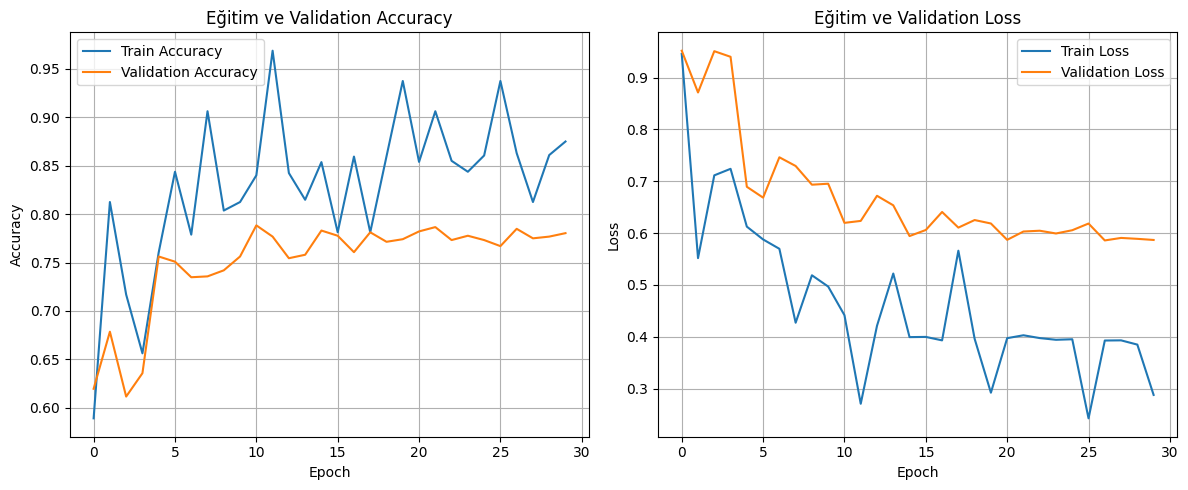

In [27]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Eğitim ve Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Eğitim ve Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- Model, başlangıçta düşük doğrulukla başlamıştır (%25–%70) ve validation doğruluğu %61–%68 civarında olmuştur. Modeli henüz veriyi tam olarak öğrenememiştir.
- Orta evrede doğruluk hızla yükselmiştir, validation accuracy %75 civarına ulaşmıştır. Model, eğitim verisine daha iyi uyum sağlamaya başlamıştır.
- Learning rate düşürüldükten sonra model stabil hâle gelmiştir ve validation accuracy %77–%78 civarında sabitlenmiştir.
- Son evrede model artık önemli ölçüde yeni bilgi öğrenememektedir, validation loss da kontrol altında kalmıştır. Model maksimum performansına yaklaşmıştır ve overfitting yapmadan öğrenmeye devam etmektedir.

#### Modelin Test Seti Üzerindeki Değerlendirmesi

In [28]:
test_loss_cnn, test_accuracy_cnn = model.evaluate(test_generator,verbose=0)
print(f"Test Kaybı: {test_loss_cnn:.4f}")
print(f"Test Doğruluğu: {test_accuracy_cnn:.4f}")

Test Kaybı: 0.8015
Test Doğruluğu: 0.7391


#### Confusion Matrix
Modelin her sınıfı ne kadar doğru tahmin ettiğini gösterir.
- Gerçek sınıflar ile modelin tahmin ettiği sınıflar karşılaştırıldı.  
- Hangi sınıflarda doğru veya yanlış tahminler yapıldığını görselleştirmek için heatmap çizildi.  

In [29]:
# Test seti üzerinde tahmin yaparız
test_generator.reset()  
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step


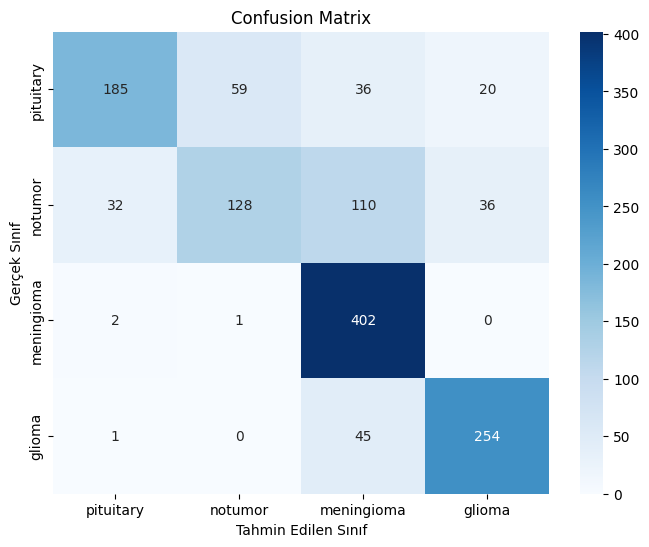

In [30]:
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Confusion Matrix")
plt.show()

#### Classification Report
Classification report, her sınıf için detaylı performans metriklerini içerir:  
- **Precision:** Modelin o sınıfa yaptığı tahminlerin doğruluk oranı.  
- **Recall:** Gerçekten o sınıfa ait örneklerin ne kadarının doğru tahmin edildiği.  
- **F1-Score:** Precision ve Recall’un harmonik ortalaması.  

In [31]:
report = classification_report(test_generator.classes, y_pred, target_names=classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   pituitary       0.84      0.62      0.71       300
     notumor       0.68      0.42      0.52       306
  meningioma       0.68      0.99      0.81       405
      glioma       0.82      0.85      0.83       300

    accuracy                           0.74      1311
   macro avg       0.75      0.72      0.72      1311
weighted avg       0.75      0.74      0.72      1311



Modelin genel doğruluk oranı (accuracy) %74 olarak hesaplanmıştır.

#### Test Setinden Örnek Tahminler

Modelin test setindeki bazı görseller üzerindeki tahmin sonuçlarını inceleriz. Bu görseller sayesinde modelin hangi tür tümörleri daha doğru tahmin ettiğini ve hangi sınıflarda hatalar yaptığını görsel olarak analiz edebiliriz.

In [32]:
# Test setinden bazı örnekleri alırız
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step


In [33]:
# Doğru ve yanlış tahminleri buluruz
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

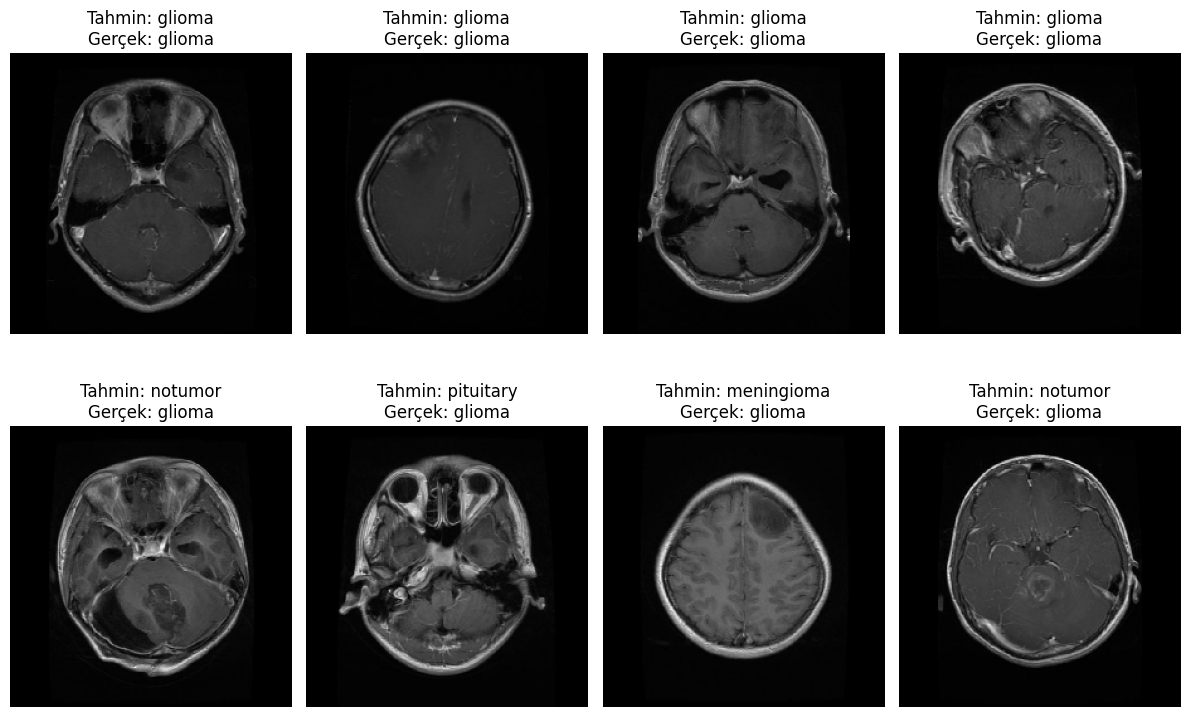

In [34]:
plt.figure(figsize=(12, 8))

# Doğru tahmin örnekleri (4 görsel)
for i, correct in enumerate(correct_indices[:4]):
    img_path = test_generator.filepaths[correct]
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Tahmin: {class_names[y_pred_classes[correct]]}\nGerçek: {class_names[y_true[correct]]}")
    plt.axis('off')

# Yanlış tahmin örnekleri (4 görsel)
for i, incorrect in enumerate(incorrect_indices[:4]):
    img_path = test_generator.filepaths[incorrect]
    img = image.load_img(img_path, target_size=(224, 224))
    plt.subplot(2, 4, i+5)
    plt.imshow(img)
    plt.title(f"Tahmin: {class_names[y_pred_classes[incorrect]]}\nGerçek: {class_names[y_true[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 7. Transfer Learning

Bu projede, önceden ImageNet üzerinde eğitilmiş **VGG16** modeli kullanılarak **transfer learning** uygulanmıştır.  

1. **Temel Model (Base Model)**: VGG16, üst katmanları dahil edilmeden (`include_top=False`) yüklenmiştir.  
2. **Katman Dondurma**: Temel modelin tüm katmanları dondurularak (`trainable=False`) eğitilmeleri engellenmiştir.  
3. **Yeni Katmanlar**: Üzerine Global Average Pooling, Dense ve Dropout katmanları eklendi ve çıkış katmanı 4 sınıf için softmax ile oluşturulmuştur.  
4. **Derleme ve Eğitim**: Model `Adam` optimizörü ve `categorical_crossentropy` kaybı ile derlendi ve eğitim seti üzerinde 20 epoch boyunca eğitilmiştir.  
5. **Test Değerlendirmesi**: Transfer learning modeli test seti üzerinde doğruluk ölçümü yapılmıştır.

Bu yöntem, temel modelin önceden öğrenilmiş özelliklerini kullanarak daha hızlı ve genellikle daha yüksek doğrulukla sınıflandırma yapmamızı sağlar.

In [35]:
base_model = VGG16(weights='imagenet',
                                     include_top=False,
                                     input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:
for layer in base_model.layers:
    layer.trainable = False

In [37]:
transfer_model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 sınıf
])

In [38]:
transfer_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
history_transfer = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20
)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 59s 346ms/step - accuracy: 0.5470 - loss: 1.0548 - val_accuracy: 0.6830 - val_loss: 0.8685
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8125 - loss: 0.4604 - val_accuracy: 0.6634 - val_loss: 0.8834
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - accuracy: 0.7969 - loss: 0.5420 - val_accuracy: 0.7188 - val_loss: 0.7277
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.6562 - loss: 0.7091 - val_accuracy: 0.7116 - val_loss: 0.7455
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 287ms/step - accuracy: 0.8299 - loss: 0.4491 - val_accuracy: 0.7500 - val_loss: 0.6973
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7500 - loss: 0.5334 - val_accuracy: 0.7536 - val_loss: 0.6909
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.8473 - loss: 0.4146 - val_accuracy: 0.7312 - val_loss: 0.7032
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8438 - loss: 0.4038 - 

In [40]:
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(test_generator, verbose=0)
print(f"Transfer Learning Test Doğruluğu: {test_accuracy_transfer:.4f}")

Transfer Learning Test Doğruluğu: 0.8337


## 8. Model Performans Karşılaştırması

Eğitim süreci tamamlandıktan sonra, **CNN** ve **Transfer Learning (VGG16)** modellerinin test seti üzerindeki doğrulukları karşılaştırılmıştır. 

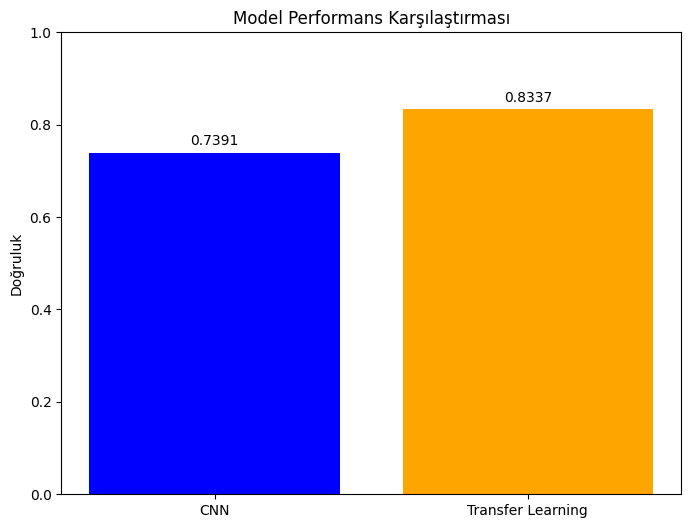

In [41]:
models = ['CNN', 'Transfer Learning']
accuracies = [test_accuracy_cnn, test_accuracy_transfer]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Doğruluk')
plt.ylim(0, 1)

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()

## 9. Hiperparametre Optimizasyonu

Model performansını artırmak için farklı hiperparametre kombinasyonları test edilmiştir. Bu amaçla **Random Search** yöntemi uygulanmıştır. 

- **Yöntem:**  
  - Rastgele seçilen 10 farklı hiperparametre kombinasyonu ile model eğitilmiştir ve validation doğrulukları kaydedilmiştir.  
  - En iyi validation doğruluğu (validation accuracy) sağlayan hiperparametreler belirlenmiştir.  

- **Sonuçlar:**  
  - Hiperparametrelerin etkisi grafiklerle incelenmiştir:   
    - **Filtre sayısına göre doğruluk:** Filtre sayısı arttıkça modelin öğrenme kapasitesi artar.  
    - **Dropout ve Dense layer kombinasyonu:** Doğruluk açısından optimal kombinasyon heatmap ile gösterilmiştir.  
    - **Optimizer türüne göre doğruluk:** Adam ve RMSprop optimizasyon algoritmaları karşılaştırılmıştır.  

In [42]:
# Hiperparametre aralıkları
param_grid = {
    'filters': [32, 64],              # Her conv katmanı için filtre sayısı
    'kernel': [3, 5],                 # Kernel boyutu
    'dropout': [0.3, 0.5],            # Dropout oranı
    'dense': [64, 128],               # Fully connected layer nöron sayısı
    'learning_rate': [1e-4, 1e-3],
    'optimizer': ['Adam', 'RMSprop']
}

In [43]:
# Model oluşturma fonksiyonu

def create_model(params):
    filters, kernel, dropout, dense, lr, opt_name = params
    
    model = Sequential([
        Conv2D(filters, (kernel, kernel), activation='relu', input_shape=(150,150,3)),
        MaxPooling2D((2,2)),
        Conv2D(filters*2, (kernel, kernel), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(filters*4, (kernel, kernel), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(dense, activation='relu'),
        Dropout(dropout),
        Dense(4, activation='softmax')  # 4 sınıf
    ])
    
    # Optimizer seçimi
    if opt_name == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [44]:
# Rastgele 10 kombinasyon deneme

param_combinations = list(itertools.product(
    param_grid['filters'], param_grid['kernel'], param_grid['dropout'],
    param_grid['dense'], param_grid['learning_rate'], param_grid['optimizer']
))

results_list = []
best_acc = 0
best_params = None

for i, params in enumerate(random.sample(param_combinations, 10)):
    print(f"\nDeneme {i+1}/10: {params}")
    model = create_model(params)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=3,
        class_weight=class_weights_dict,
        verbose=0
    )
    
    val_acc = max(history.history['val_accuracy'])
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    results_list.append({
        'filters': params[0],
        'kernel': params[1],
        'dropout': params[2],
        'dense': params[3],
        'learning_rate': params[4],
        'optimizer': params[5],
        'val_accuracy': val_acc
    })
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params


Deneme 1/10: (64, 5, 0.5, 64, 0.001, 'Adam')
Validation Accuracy: 0.6839

Deneme 2/10: (64, 3, 0.3, 64, 0.001, 'RMSprop')
Validation Accuracy: 0.6652

Deneme 3/10: (64, 5, 0.5, 64, 0.001, 'RMSprop')
Validation Accuracy: 0.6946

Deneme 4/10: (64, 5, 0.5, 128, 0.001, 'Adam')
Validation Accuracy: 0.6973

Deneme 5/10: (32, 3, 0.3, 64, 0.001, 'RMSprop')
Validation Accuracy: 0.6696

Deneme 6/10: (32, 3, 0.3, 64, 0.001, 'Adam')
Validation Accuracy: 0.7125

Deneme 7/10: (32, 3, 0.5, 128, 0.0001, 'RMSprop')
Validation Accuracy: 0.6795

Deneme 8/10: (64, 3, 0.3, 128, 0.001, 'RMSprop')
Validation Accuracy: 0.6777

Deneme 9/10: (64, 5, 0.3, 64, 0.0001, 'Adam')
Validation Accuracy: 0.6661

Deneme 10/10: (32, 5, 0.5, 128, 0.001, 'Adam')
Validation Accuracy: 0.6616


In [45]:
print("En İyi Parametreler:", best_params)
print(" ")
print(f"- Filtre Sayısı (filters): {best_params[0]}")
print(f"- Kernel Boyutu (kernel): {best_params[1]}")
print(f"- Dropout Oranı (dropout): {best_params[2]}")
print(f"- Dense Layer Nöron Sayısı (dense): {best_params[3]}")
print(f"- Learning Rate: {best_params[4]}")
print(f"- Optimizer Türü: {best_params[5]}\n")

print(f"En İyi Validation Accuracy: {best_acc:.4f}")

En İyi Parametreler: (32, 3, 0.3, 64, 0.001, 'Adam')
 
- Filtre Sayısı (filters): 32
- Kernel Boyutu (kernel): 3
- Dropout Oranı (dropout): 0.3
- Dense Layer Nöron Sayısı (dense): 64
- Learning Rate: 0.001
- Optimizer Türü: Adam

En İyi Validation Accuracy: 0.7125


   filters  kernel  dropout  dense  learning_rate optimizer  val_accuracy
0       64       5      0.5     64         0.0010      Adam      0.683929
1       64       3      0.3     64         0.0010   RMSprop      0.665179
2       64       5      0.5     64         0.0010   RMSprop      0.694643
3       64       5      0.5    128         0.0010      Adam      0.697321
4       32       3      0.3     64         0.0010   RMSprop      0.669643
5       32       3      0.3     64         0.0010      Adam      0.712500
6       32       3      0.5    128         0.0001   RMSprop      0.679464
7       64       3      0.3    128         0.0010   RMSprop      0.677679
8       64       5      0.3     64         0.0001      Adam      0.666071
9       32       5      0.5    128         0.0010      Adam      0.661607


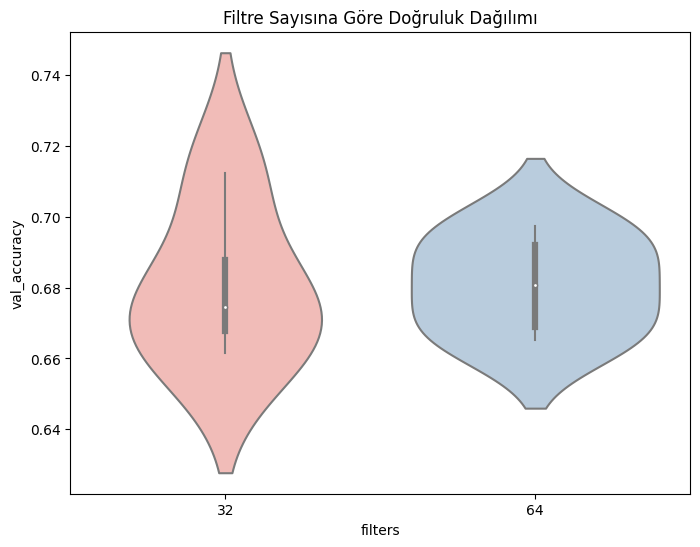

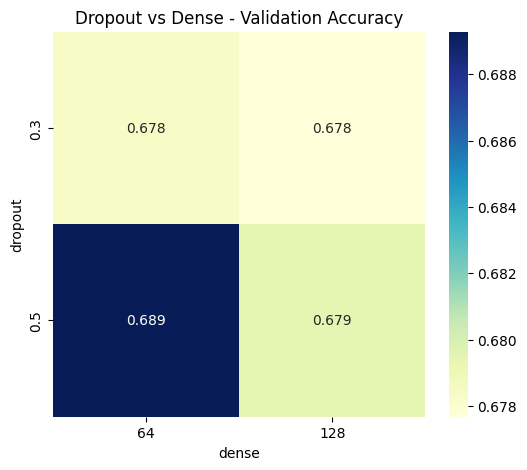

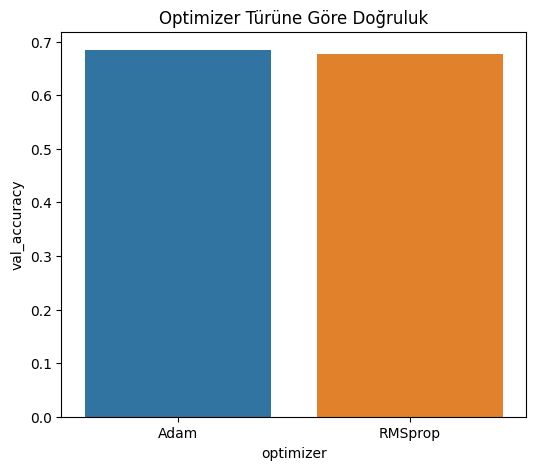

In [46]:
# Sonuçları DataFrame'e dönüştürme ve görselleştirme
df_results = pd.DataFrame(results_list)
print(df_results)

# Grafikler

# Filtre sayısına göre doğruluk dağılımı
plt.figure(figsize=(8,6))
sns.violinplot(x='filters', y='val_accuracy', data=df_results, inner='box', palette='Pastel1')
plt.title('Filtre Sayısına Göre Doğruluk Dağılımı')
plt.show()

# Dropout ve Dense Layer kombinasyonu için heatmap
heatmap_data = df_results.pivot_table(values='val_accuracy', index='dropout', columns='dense')
plt.figure(figsize=(6,5))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='YlGnBu')
plt.title('Dropout vs Dense - Validation Accuracy')
plt.show()

# Optimizer bazlı doğruluk dağılımı
plt.figure(figsize=(6,5))
sns.barplot(x='optimizer', y='val_accuracy', data=df_results, ci=None)
plt.title('Optimizer Türüne Göre Doğruluk')
plt.show()

## 10. Model İzleme

Modelin eğitim sürecini izlemek için TensorBoard kullanıldı. Bu sayede epoch başına eğitim/doğrulama kaybı ve doğruluk değerlerini görselleştirebiliriz.

In [47]:
# Log dizini
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [48]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.7427 - loss: 0.6403 - val_accuracy: 0.7045 - val_loss: 0.7813
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9062 - loss: 0.3330 - val_accuracy: 0.6598 - val_loss: 0.9547
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.7953 - loss: 0.5496 - val_accuracy: 0.6973 - val_loss: 0.7694
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7188 - loss: 0.5714 - val_accuracy: 0.7054 - val_loss: 0.7185
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.8064 - loss: 0.5017 - val_accuracy: 0.7482 - val_loss: 0.6757
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8438 - loss: 0.3258 - val_accuracy: 0.7518 - val_loss: 0.6350
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - accuracy: 0.8311 - loss: 0.4520 - val_accuracy: 0.7018 - val_loss: 0.7581
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.6562 - loss: 0.7203 -

TensorBoard’u notebook içinde başlatmak için:

In [49]:
%load_ext tensorboard

In [50]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

Kaggle ortamında bazen %tensorboard görünmeyebilir bu durumda log dosyalarını zip hâline getirip bilgisayarınızda açabilirsiniz.

In [51]:
# Log dosyalarını zip hâline getirme

import shutil
shutil.make_archive("/kaggle/working/logs_fit", 'zip', "/kaggle/working/logs/fit")

'/kaggle/working/logs_fit.zip'

##### Zip dosyasını indirme:
- Notebook’un sol panelinden “Data” sekmesine gidin.
- /kaggle/working/logs_fit.zip dosyasını bulun ve indirin.
- İndirdikten sonra zip dosyasını çıkartın.

##### Kendi bilgisayarınızda TensorBoard ile açma
- Terminal veya komut satırında şu komutu çalıştırın:
    - tensorboard --logdir= "path_to_logs" --port=6007

Bu sayede eğitim sırasında kaydedilen accuracy, loss ve diğer metrikleri görselleştirerek modelin performansını inceleyebilirsiniz.

##  11. Sonuçlar ve Değerlendirme

In [52]:
print("=" * 50)
print("BRAIN TUMOR MRI SINIFLANDIRMA PROJE SONUÇLARI")
print("=" * 50)
print(f"CNN Model Test Doğruluğu: {test_accuracy_cnn:.4f}")
print(f"Transfer Learning Model Test Doğruluğu: {test_accuracy_transfer:.4f}")

BRAIN TUMOR MRI SINIFLANDIRMA PROJE SONUÇLARI
CNN Model Test Doğruluğu: 0.7391
Transfer Learning Model Test Doğruluğu: 0.8337


## Proje Genel Değerlendirmesi

Bu proje kapsamında, beyin tümörü MRI görüntülerinin sınıflandırılması için **Convolutional Neural Network (CNN)** ve **Transfer Learning (VGG16)** yöntemleri uygulanmıştır.  

**Öne çıkan noktalar:**
- CNN modeli, temel evrişim katmanları ve fully connected katmanları ile 4 sınıfı başarıyla ayırt edebilmektedir.  
- Transfer Learning yaklaşımı, önceden eğitilmiş VGG16 modelini kullanarak daha hızlı ve yüksek doğruluk sağlamaktadır.  
- Model performansı, eğitim ve doğrulama süreçlerinde **accuracy** ve **loss** grafikleri ile izlenmiştir, ayrıca **confusion matrix** ve **classification report** ile test seti değerlendirilmiştir.  
- Hiperparametre optimizasyonu ile filtre sayısı, dropout oranı, dense nöron sayısı ve optimizer türü gibi parametrelerin etkisi incelenmiştir ve en iyi parametre kombinasyonu belirlenmiştir.  
- TensorBoard entegrasyonu sayesinde eğitim sürecindeki metrikler görselleştirilmiştir ve detaylı analiz yapılabilmiştir.  

**Sonuç olarak:**  
Her iki model de MRI görüntülerinden tümör tiplerini tahmin etmede başarılı performans göstermiştir. Transfer Learning, sınırlı veri seti ve eğitim süresi göz önünde bulundurulduğunda özellikle yüksek doğruluk ve hızlı eğitim avantajı sunmaktadır. Bu model, tıbbi görüntü analizi ve otomatik tümör sınıflandırması gibi uygulamalarda kullanılabilir.
